# KNN model for predicting racket age using datasets P1, P2, and P3, based on **energy per band features** - Sound

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the age of a racket (P1, P2, P3) based on sound features extracted from audio files. The workflow involves reading `.wav` files, **extracting energy per frequency band** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [3]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys

### Import Tools Functions

In [4]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Readwav function

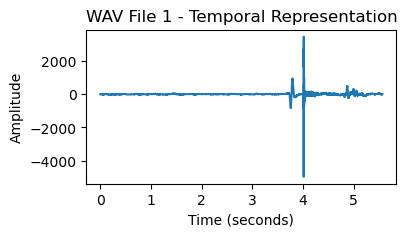

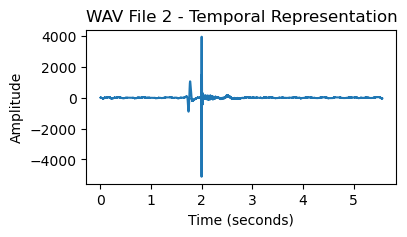

In [5]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

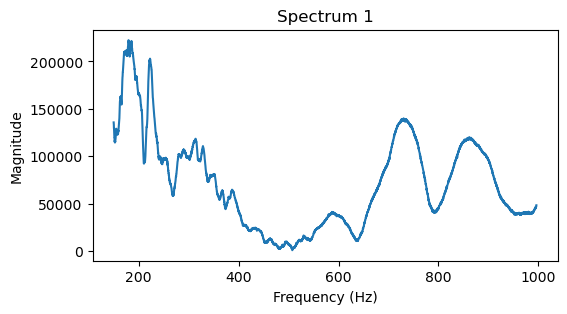

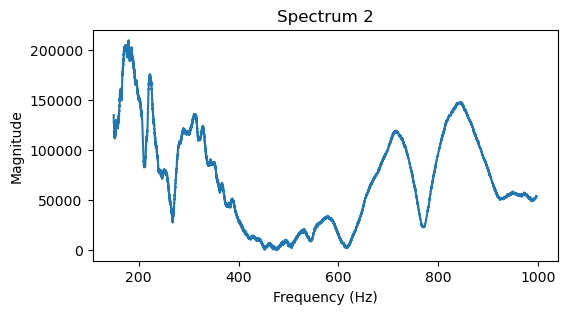

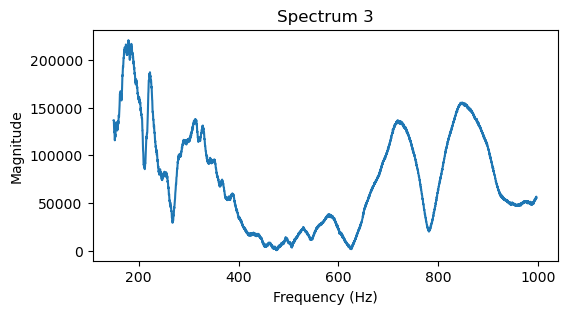

In [6]:
from spectrumFromSignal import spectrumFromSignal


spectrumVect=[]

for i in range(len(testWavFileVect)):
    spectrum,freqs= spectrumFromSignal(testWavFileVect[i],samplerateVect[i])
    spectrumVect.append(spectrum)

for idx, spectrum in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs[:len(spectrum)], spectrum)  # Associate frequencies with the spectrum
    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()



Energy

In [7]:
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum

# Main

### Data Preparation and Label Encoding

In [8]:
raquetteTypeList = {"RB":0,"RO":1,"RR":2,"RV":3}
raquetteAgeList = {"P1":1,"P2":2,"P3":3}


allWavFile=[]
allWavFileSampleRate=[]
allWavFileLabel=[]
allWavFileP1=[]
allWavFileP2=[]
allWavFileP3=[]

sampleRateFolderP1=[]
sampleRateFolderP2=[]
sampleRateFolderP3=[]

#P1
sampleRateFolderP1,allWavFileP1,filesP1 =readWavFolder("../../../Data/Sound/P1")



#P2
sampleRateFolderP2,allWavFileP2,filesP2 =readWavFolder("../../../Data/Sound/P2")



#P3
sampleRateFolderP3,allWavFileP3,filesP3 =readWavFolder("../../../Data/Sound/P3")



# Find the minimum length among the three lists
min_len = min(len(allWavFileP1), len(allWavFileP2), len(allWavFileP3))

# Reduce each list to the minimum length
allWavFileP1 = allWavFileP1[:min_len]
allWavFileP2 = allWavFileP2[:min_len]
allWavFileP3 = allWavFileP3[:min_len]

print("Len(allWavFileP1)",len(allWavFileP1),"Len(allWavFileP2)",len(allWavFileP2),"Len(allWavFileP3)",len(allWavFileP3))

# print(len(sampleRateFolderP1))

for i in range(len(allWavFileP1)):
    allWavFile.append(allWavFileP1[i])
    allWavFileSampleRate.append(sampleRateFolderP1[i])
    allWavFileLabel.append("P1")
for i in range(len(allWavFileP2)):
    allWavFile.append(allWavFileP2[i])
    allWavFileSampleRate.append(sampleRateFolderP2[i])
    allWavFileLabel.append("P2")
for i in range(len(allWavFileP3)):
    allWavFile.append(allWavFileP3[i])
    allWavFileSampleRate.append(sampleRateFolderP3[i])
    allWavFileLabel.append("P3")



Len(allWavFileP1) 213 Len(allWavFileP2) 213 Len(allWavFileP3) 213


### Feature Extraction and Normalization

In [9]:
X_HZAllWavFile = []
X_AmplitudeAllWavFile = []

# print(len(allWavFile))

for i in range(len(allWavFile)):
    # print(i)

    wavFile=allWavFile[i]
    samplerate=allWavFileSampleRate[i]

    # Compute the spectrum using FFT
    spectrum,freqs= spectrumFromSignal(wavFile,samplerate)
    
  
    # Extract peaks from the spectrum
    X_Amplitude,X_HZ = energy_per_frequency_band_from_spectrum(spectrum, freqs[(freqs >= 150) & (freqs <= 1000)], band_width=20)


    # Normalize X_Amplitude
    X_Amplitude = np.array(X_Amplitude) / np.max(X_Amplitude)


    X_HZAllWavFile.append(X_HZ)
    X_AmplitudeAllWavFile.append(X_Amplitude)


# print(X_AmplitudeAllWavFile)


In [10]:
# Combine features into X (concatenate frequency and amplitude features)
X = np.hstack([np.array(X_HZAllWavFile), np.array(X_AmplitudeAllWavFile)])
# Alternatively, use only amplitude features
# X = np.array(X_AmplitudeAllWavFile)

# Print the number of labels (should match the number of samples)
print(len(allWavFileLabel))

# Encode string labels (e.g., "P1", "P2", "P3") into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allWavFileLabel)

# Print the lengths of feature matrix X and label vector y
print(len(X), len(y))

# Split the data into training and testing sets
# 80% for training and 20% for testing, with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


639
639 639


### Hyperparameter Tuning Results

In [11]:
# Define the ranges for hyperparameters# Define the ranges for hyperparameters
n_neighbors_range = range(1, 21)  # Range of neighbors to testo test
weights_options = ['uniform', 'distance']  # Weighting methods to testg methods to test
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# List to store the results
results = []

# Test all combinations of hyperparameters
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Create and train the KNN model
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Evaluate on the test set
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Evaluate on the training set
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Add the results to the list
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)


     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean        1.000000       0.968750
1              1   uniform  manhattan        1.000000       0.976562
2              1   uniform  chebyshev        1.000000       0.960938
3              1   uniform  minkowski        1.000000       0.968750
4              1  distance  euclidean        1.000000       0.968750
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski        0.915851       0.914062
156           20  distance  euclidean        1.000000       0.929688
157           20  distance  manhattan        1.000000       0.929688
158           20  distance  chebyshev        1.000000       0.914062
159           20  distance  minkowski        1.000000       0.929688

[160 rows x 5 columns]


## Results and Visualisation

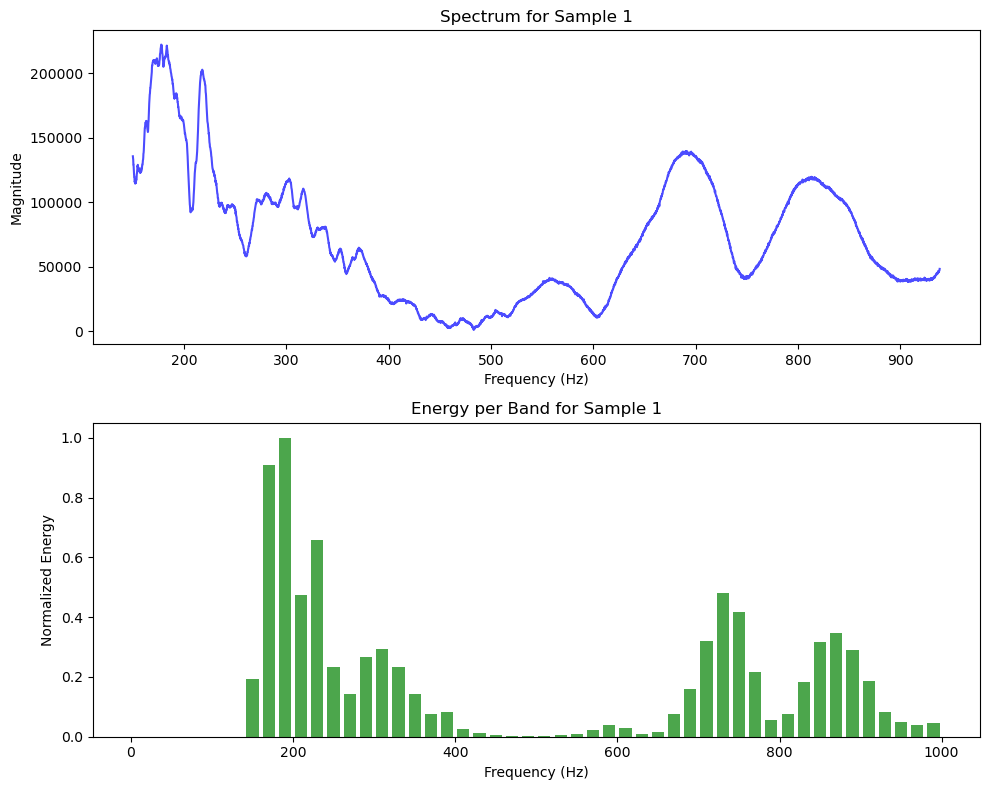

In [24]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the spectrum for the first sample
axs[0].plot(freqs[:len(spectrumVect[0])], spectrumVect[0], color='blue', alpha=0.7)
axs[0].set_title("Spectrum for Sample 1")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude")

# Plot the energy per band for the first sample
band_centers = [(freqs[0] + 20 * (i + 0.5))-150 for i in range(len(X_AmplitudeAllWavFile[0]))]
axs[1].bar(band_centers, X_AmplitudeAllWavFile[0], width=15, color='green', alpha=0.7)
axs[1].set_title("Energy per Band for Sample 1")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Normalized Energy")

# Adjust layout
plt.tight_layout()
plt.show()

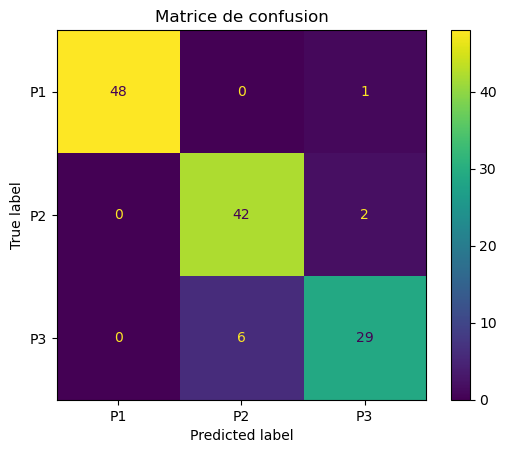

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
